#### To effectively implement an isolation forest model for anomaly detection, data cleaning is crucial to remove inaccuracies and irrelevant information. Indicative features should be selected for anomaly detection, and data should be split into training and testing sets for model preparation. Feature scaling is necessary for uniform data measurement to accurately isolate anomalies. Model performance evaluation is done using metrics like Precision, recall, and F1-score after training on cleaned data. This process ensures the robustness and effectiveness of the isolation forest model in identifying outliers in the dataset, providing a sense of security in its use.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import OneClassSVM

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 350735 to 352413
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    50000 non-null  object 
 1   Global_reactive_power  50000 non-null  object 
 2   Voltage                50000 non-null  object 
 3   Global_intensity       50000 non-null  object 
 4   Sub_metering_1         50000 non-null  object 
 5   Sub_metering_2         50000 non-null  object 
 6   Sub_metering_3         49797 non-null  float64
dtypes: float64(1), object(6)
memory usage: 3.1+ MB


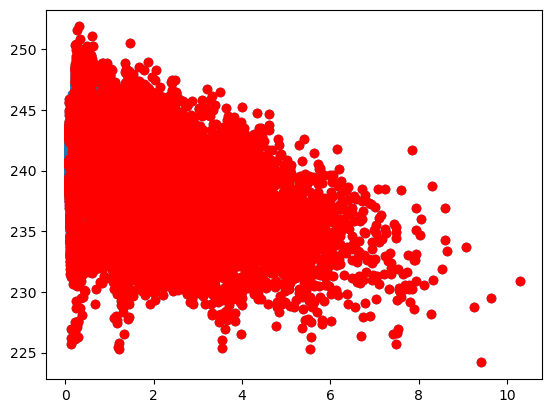

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.91      0.19       903
           1       0.97      0.26      0.40      9057

    accuracy                           0.32      9960
   macro avg       0.54      0.58      0.30      9960
weighted avg       0.89      0.32      0.39      9960



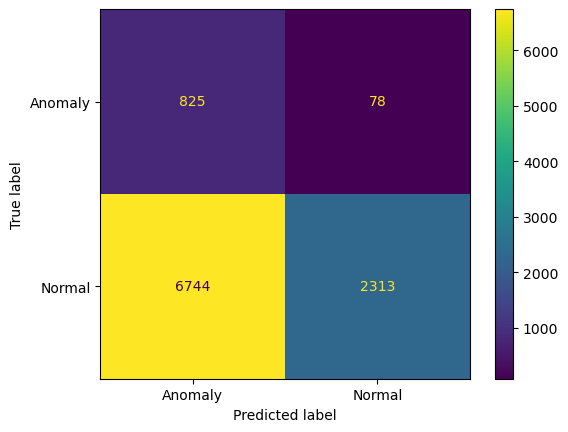

In [2]:

def anomaly_detection_isolation_forest():
    # Load the dataset
    data1 = pd.read_csv('pow_cons.csv')
    
    
    data = data1.sample(n=50000, random_state=5)
    
    data = data.drop(['Date','Time'], axis=1)
    data.info()
    
    data.dropna(axis=0, inplace=True)
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    model = OneClassSVM(kernel='rbf', gamma='auto', nu = 0.2).fit(data)
    y_pred = model.predict(data)

    anomaly_values = data.iloc[np.where(y_pred ==-1)]

    plt.scatter(data["Global_active_power"], data["Voltage"])
    plt.scatter(anomaly_values["Global_active_power"],anomaly_values["Voltage"], c="r")
    plt.show()
    
#     sns.pairplot(data, kind='scatter')
#     plt.title('Scatter Plot')
#     plt.show()
    
    X = data.drop('Global_active_power', axis=1)  # Assuming 'label' is your target column
    y_cont = data['Global_active_power']

#     # First, binarize `y` based on a chosen threshold.
    y = np.where(y_cont > 0.2, 1, 0)  # Define `threshold` based on your domain knowledge

    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=3)
    X_selected = selector.fit_transform(X, y)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and fit the Isolation Forest
    iso_forest = IsolationForest(contamination='auto', n_estimators=200, random_state=42)
    iso_forest.fit(X_train_scaled)
    
    # Predict on the test data
    y_pred = iso_forest.predict(X_test_scaled)
    # Convert predictions to match the original label (1 for normal, -1 for anomaly)
    y_pred = np.where(y_pred == 1, 0, 1)
    
    # Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    
    
    # Use a confusion matrix for visualization of the outcome
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Example usage

anomaly_detection_isolation_forest()